# Online Retail - Customer Segmentaion Project - K-Means Clustering

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

In [2]:
# disable warnings
import warnings
warnings.filterwarnings('ignore')

Dataset available at: https://archive.ics.uci.edu/static/public/352/online+retail.zip

This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

**Variable Information**
- InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation. 
- StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
- Description: Product (item) name. Nominal.
- Quantity: The quantities of each product (item) per transaction. Numeric.	
- InvoiceDate: Invoice Date and time. Numeric, the day and time when each transaction was generated.
- UnitPrice: Unit price. Numeric, Product price per unit in sterling.
- CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
- Country: Country name. Nominal, the name of the country where each customer resides. 

In [3]:
%%time
# load the dataset
df = pd.read_excel('Online Retail.xlsx') 

CPU times: total: 40 s
Wall time: 40.3 s


In [4]:
# uncomment to keep a copy of the dataset
# dfo = df.copy()

In [5]:
df.shape

(541909, 8)

In [6]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


### Data Preprocessing

In [8]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [9]:
# removing the entries with missing CustomerID
s = len(df)
df.dropna(subset='CustomerID', inplace=True)
print(f'{s - len(df)} entries removed')

135080 entries removed


In [10]:
df['Description'].isnull().sum()

0

It seems that all the entries where the Discription was missing also had a missing CustomerID and they got removed.

In [11]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

"InvoiceNo" is an object type, with some entries being purely numeric and others containing 'C' to denote cancellation. We aim to ensure 'C' is the only letter present. We then remove letters, create a binary 'Cancelled' column (1 for cancelled, 0 for paid), and convert "InvoiceNo" to an integer type.

In [12]:
# Filter the DataFrame 'df' to only include rows where 'InvoiceNo' contains any letter (a-z or A-Z)
invoices_withLetters = df[df['InvoiceNo'].str.contains(r'[a-zA-Z]', na=False)]

# Extract all letters from 'InvoiceNo' and create a new DataFrame 'letters'
letters = df['InvoiceNo'].str.extractall(r'([a-zA-Z])')

# Print unique letters found in 'InvoiceNo'
print(letters.iloc[:, -1].unique())

# Display the first few rows of the filtered DataFrame 'invoices_withLetters'
invoices_withLetters.head()

['C']


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


We can see that there is only the 'C' letter present in some codes, which are the cancelled ones.

Data inspection reveals that cancelled invoices correspond to negative quantities. Let's verify that all such invoices are included in the `invoices_withLetters` DataFrame.

In [13]:
print(invoices_withLetters.shape)
print((invoices_withLetters['Quantity'] >= 0).sum())
print((df['Quantity'] <= 0).sum())

(8905, 8)
0
8905


We conclude that only the cancelled invoices (which have the letter 'C' in their InvoiceNo have negative Quantity values.

In [14]:
# Creating a Cancelled column with binary values; 1 for cancelled and 0 for successfull
f = lambda x: 1 if x < 0 else 0
df['Cancelled'] = df['Quantity'].apply(f)
df['Cancelled'].sum()

8905

In [15]:
# Removing the letter 'C' from the cancelled invoices
def remove_letter_C(value):
    if type(value) == str:
        return value.replace('C', '')
    else:
        return value
df['InvoiceNo'] = df['InvoiceNo'].apply(remove_letter_C)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
 8   Cancelled    406829 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 31.0+ MB


Next, we reduce the size of our dataset in the memory by casting the column values in the smallest data type that is suitable.

In [17]:
df['InvoiceNo'] = df['InvoiceNo'].astype('uint32')

In [18]:
df['Quantity'] = df['Quantity'].astype('int32')

In [19]:
df['UnitPrice'] = df['UnitPrice'].astype('float32')

In [20]:
df['CustomerID'] = df['CustomerID'].astype('uint32')

In [21]:
df['Cancelled'] = df['Cancelled'].astype('uint8')

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  uint32        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int32         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float32       
 6   CustomerID   406829 non-null  uint32        
 7   Country      406829 non-null  object        
 8   Cancelled    406829 non-null  uint8         
dtypes: datetime64[ns](1), float32(1), int32(1), object(3), uint32(2), uint8(1)
memory usage: 22.1+ MB


We reduced the memory usage by 11 MB

### Feature Extraction

Next, we aim to derive features likely beneficial for customer segmentation.

Features to extract:

- (done) total price paid to company for each customer
- (done) total number of paid invoices per customer.
- (done) total quantity of paid per customer.
- (done) mean unit price per customer.
- (done) mean price per paid invoice per customer.
- (done) mean quantity per paid invoice per customer.
- (done) mean time difference between invoices per customer.
- (done) percentage of paid invoices out of all invoices per customer.

In this code, I calculate the total price for each item, adjust for cancelled invoices, and compute the total expenditure for each customer. The total price is rounded to two decimal places for accuracy. This prepares the data for further analysis.

In [23]:
# Create a new column 'TotalPrice' in the DataFrame 'df' that represents the total price
# of each item by multiplying 'Quantity' and 'UnitPrice'
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Replace negative values in 'TotalPrice' with 0 (which correspond to cancelled invoices) to
# ensure accurate total price calculation
df['TotalPrice'] = df['TotalPrice'].apply(lambda x: 0 if x < 0 else x)

# Round the 'TotalPrice' values to 2 decimal places for better readability and accuracy
df['TotalPrice'] = df['TotalPrice'].round(2)

# Create a new column 'TotalExpenditure' in the DataFrame 'df' that represents the
# total expenditure for each customer by summing 'TotalPrice' for each 'CustomerID'
df['TotalExpenditure'] = df.groupby('CustomerID')['TotalPrice'].transform('sum')


In [24]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled,TotalPrice,TotalExpenditure
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0,15.30,5391.21
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,5391.21
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0,22.00,5391.21
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,5391.21
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,5391.21


In [25]:
non_cancelled_df = df[df['Cancelled'] == 0]
non_cancelled_df.shape

(397924, 11)

In [26]:
cancelled_df = df[df['Cancelled'] == 1]
cancelled_df.shape

(8905, 11)

Now, calculate the total quantity per customer and add it to a new column

In [27]:
# Calculate the total quantity of items purchased by each customer in the 'non_cancelled_df' DataFrame
tot_quantity_perCustomer = non_cancelled_df.groupby('CustomerID')['Quantity'].sum()

# Map the total quantity per customer to the main DataFrame 'df' using 'CustomerID'
df['TotalQuantity'] = df['CustomerID'].map(tot_quantity_perCustomer)

# Replace any NaN values in the 'TotalQuantity' column with 0
df['TotalQuantity'].fillna(0, inplace=True)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled,TotalPrice,TotalExpenditure,TotalQuantity
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0,15.30,5391.21,1733.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,5391.21,1733.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0,22.00,5391.21,1733.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,5391.21,1733.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,5391.21,1733.0


Creating a new column for the number of paid invoices for each customer

In [28]:
# Calculate the number of paid invoices for each customer
nOf_paid_invoices = non_cancelled_df.groupby('CustomerID')['InvoiceNo'].nunique()

# Add this information to the main DataFrame
df['nOfPaidInvoices'] = df['CustomerID'].map(nOf_paid_invoices)

# Replace NaN values with 0
df['nOfPaidInvoices'].fillna(0, inplace=True)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled,TotalPrice,TotalExpenditure,TotalQuantity,nOfPaidInvoices
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0,15.30,5391.21,1733.0,34.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,5391.21,1733.0,34.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0,22.00,5391.21,1733.0,34.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,5391.21,1733.0,34.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,5391.21,1733.0,34.0


Creating a new column for the number of cancelled invoices for each customer

In [29]:
# Calculate the number of cancelled invoices for each customer
nOf_cancelled_invoices = cancelled_df.groupby('CustomerID')['InvoiceNo'].nunique()

# Add this information to the main DataFrame
df['nOfCancelledInvoices'] = df['CustomerID'].map(nOf_cancelled_invoices)

# Replace NaN values with 0
df['nOfCancelledInvoices'].fillna(0, inplace=True)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled,TotalPrice,TotalExpenditure,TotalQuantity,nOfPaidInvoices,nOfCancelledInvoices
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0,15.30,5391.21,1733.0,34.0,1.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,5391.21,1733.0,34.0,1.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0,22.00,5391.21,1733.0,34.0,1.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,5391.21,1733.0,34.0,1.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,5391.21,1733.0,34.0,1.0


In [30]:
# Calculate the percentage of paid invoices
df['percentageOfPaidInvoices'] = df['nOfPaidInvoices'] / (df['nOfPaidInvoices'] + df['nOfCancelledInvoices'])

# Calculate the mean unit price
df['meanUnitPrice'] = df['TotalExpenditure'] / df['TotalQuantity']

# Calculate the mean invoice price
df['meanInvoicePrice'] = df['TotalExpenditure'] / df['nOfPaidInvoices']

# Calculate the mean invoice quantity
df['meanInvoiceQuantity'] = df['TotalQuantity'] / df['nOfPaidInvoices']

In [31]:
# replace NaN values with 0
df.fillna(0, inplace=True)

In [32]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled,TotalPrice,TotalExpenditure,TotalQuantity,nOfPaidInvoices,nOfCancelledInvoices,percentageOfPaidInvoices,meanUnitPrice,meanInvoicePrice,meanInvoiceQuantity
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0,15.30,5391.21,1733.0,34.0,1.0,0.971429,3.110912,158.565,50.970588
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,5391.21,1733.0,34.0,1.0,0.971429,3.110912,158.565,50.970588
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0,22.00,5391.21,1733.0,34.0,1.0,0.971429,3.110912,158.565,50.970588
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,5391.21,1733.0,34.0,1.0,0.971429,3.110912,158.565,50.970588
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,5391.21,1733.0,34.0,1.0,0.971429,3.110912,158.565,50.970588


Next, we will calculate the average time difference between each customer's invoice dates. This provides insight into their purchasing frequency.

In [33]:
def mean_InvoiceDate_diff(timeArray):
    """
    Calculate the mean difference between invoice dates in hours.

    Parameters:
    timeArray (array-like): An array of datetime objects representing invoice dates.

    Returns:
    float: The mean difference between invoice dates in hours.
    """
    arr_size = timeArray.size
    if arr_size == 1:
        return 0
    else:
        timeArray_rev = timeArray[::-1]
        time_diff_list = []
        for i in range(arr_size):
            try:
                time_diff = timeArray_rev[i] - timeArray_rev[i+1]
                time_diff_hours = time_diff.total_seconds() / 3600
                time_diff_list.append(time_diff_hours)
            except:
                break
        return sum(time_diff_list)/len(time_diff_list)

In [34]:
# Group the DataFrame 'non_cancelled_df' by 'CustomerID' and get unique 'InvoiceDate' for each customer
invoiceDates_perCustomer = non_cancelled_df.groupby('CustomerID')['InvoiceDate'].unique()

# Apply the 'mean_InvoiceDate_diff' function to each customer's invoice dates to calculate the mean difference between invoice dates
mean_InvoiceDate_diff_perCustomer = invoiceDates_perCustomer.apply(mean_InvoiceDate_diff)

# Display the first few rows of the calculated mean differences
mean_InvoiceDate_diff_perCustomer.head()

CustomerID
12346       0.000000
12347    1460.152778
12348    2262.022222
12349       0.000000
12350       0.000000
Name: InvoiceDate, dtype: float64

In [35]:
# Add this information to the main DataFrame
df['meanInvoiceDateDifference(hours)'] = df['CustomerID'].map(mean_InvoiceDate_diff_perCustomer)

# Replace NaN values with 0
df['meanInvoiceDateDifference(hours)'].fillna(0, inplace=True)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled,TotalPrice,TotalExpenditure,TotalQuantity,nOfPaidInvoices,nOfCancelledInvoices,percentageOfPaidInvoices,meanUnitPrice,meanInvoicePrice,meanInvoiceQuantity,meanInvoiceDateDifference(hours)
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0,15.30,5391.21,1733.0,34.0,1.0,0.971429,3.110912,158.565,50.970588,0.969271
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,5391.21,1733.0,34.0,1.0,0.971429,3.110912,158.565,50.970588,0.969271
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0,22.00,5391.21,1733.0,34.0,1.0,0.971429,3.110912,158.565,50.970588,0.969271
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,5391.21,1733.0,34.0,1.0,0.971429,3.110912,158.565,50.970588,0.969271
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,5391.21,1733.0,34.0,1.0,0.971429,3.110912,158.565,50.970588,0.969271


In [36]:
df['meanInvoiceDateDifference(hours)'].describe()

count    406829.000000
mean       1039.401069
std        1164.543083
min           0.000000
25%         300.779167
50%         730.122222
75%        1352.216667
max        8783.566667
Name: meanInvoiceDateDifference(hours), dtype: float64

In [37]:
# encoding the Country column
# Get value counts
counts = df['Country'].value_counts(ascending=True)

# Create a dictionary mapping each unique value to its count
mapping = {country: i for i, country in enumerate(counts.index, start=1)}

# Replace the values in the column
df['Country_encoded'] = df['Country'].map(mapping)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled,TotalPrice,TotalExpenditure,TotalQuantity,nOfPaidInvoices,nOfCancelledInvoices,percentageOfPaidInvoices,meanUnitPrice,meanInvoicePrice,meanInvoiceQuantity,meanInvoiceDateDifference(hours),Country_encoded
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0,15.30,5391.21,1733.0,34.0,1.0,0.971429,3.110912,158.565,50.970588,0.969271,37
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,5391.21,1733.0,34.0,1.0,0.971429,3.110912,158.565,50.970588,0.969271,37
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0,22.00,5391.21,1733.0,34.0,1.0,0.971429,3.110912,158.565,50.970588,0.969271,37
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,5391.21,1733.0,34.0,1.0,0.971429,3.110912,158.565,50.970588,0.969271,37
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,5391.21,1733.0,34.0,1.0,0.971429,3.110912,158.565,50.970588,0.969271,37


In [38]:
# extracting the features that only relate to individual customers
customer_df = pd.concat([df['CustomerID'],df.loc[:, 'TotalExpenditure':]], axis=1)
customer_df.head()

,CustomerID,TotalExpenditure,TotalQuantity,nOfPaidInvoices,nOfCancelledInvoices,percentageOfPaidInvoices,meanUnitPrice,meanInvoicePrice,meanInvoiceQuantity,meanInvoiceDateDifference(hours),Country_encoded
0,17850,5391.21,1733.0,34.0,1.0,0.971429,3.110912,158.565,50.970588,0.969271,37
1,17850,5391.21,1733.0,34.0,1.0,0.971429,3.110912,158.565,50.970588,0.969271,37
2,17850,5391.21,1733.0,34.0,1.0,0.971429,3.110912,158.565,50.970588,0.969271,37
3,17850,5391.21,1733.0,34.0,1.0,0.971429,3.110912,158.565,50.970588,0.969271,37
4,17850,5391.21,1733.0,34.0,1.0,0.971429,3.110912,158.565,50.970588,0.969271,37


In [39]:
# remove the duplicates to only keep one entry per customer
customer_df.drop_duplicates(inplace=True)
customer_df.head()

,CustomerID,TotalExpenditure,TotalQuantity,nOfPaidInvoices,nOfCancelledInvoices,percentageOfPaidInvoices,meanUnitPrice,meanInvoicePrice,meanInvoiceQuantity,meanInvoiceDateDifference(hours),Country_encoded
0,17850,5391.21,1733.0,34.0,1.0,0.971429,3.110912,158.565000,50.970588,0.969271,37
9,13047,3237.54,1391.0,10.0,8.0,0.555556,2.327491,323.754000,139.100000,1026.441667,37
26,12583,7281.38,5060.0,15.0,3.0,0.833333,1.439008,485.425333,337.333333,635.954762,35
46,13748,948.25,439.0,5.0,0.0,1.000000,2.160023,189.650000,87.800000,2224.250000,37
65,15100,876.00,80.0,3.0,3.0,0.500000,10.950000,292.000000,26.666667,480.716667,37


### Model Development

In [40]:
from sklearn.cluster import KMeans

In [41]:
# get the features, excluding the CustomerID
X = customer_df.iloc[:, 1:]
X.head()

,TotalExpenditure,TotalQuantity,nOfPaidInvoices,nOfCancelledInvoices,percentageOfPaidInvoices,meanUnitPrice,meanInvoicePrice,meanInvoiceQuantity,meanInvoiceDateDifference(hours),Country_encoded
0,5391.21,1733.0,34.0,1.0,0.971429,3.110912,158.565000,50.970588,0.969271,37
9,3237.54,1391.0,10.0,8.0,0.555556,2.327491,323.754000,139.100000,1026.441667,37
26,7281.38,5060.0,15.0,3.0,0.833333,1.439008,485.425333,337.333333,635.954762,35
46,948.25,439.0,5.0,0.0,1.000000,2.160023,189.650000,87.800000,2224.250000,37
65,876.00,80.0,3.0,3.0,0.500000,10.950000,292.000000,26.666667,480.716667,37


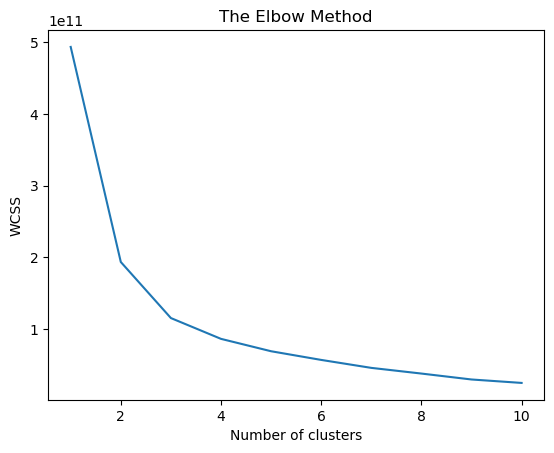

CPU times: total: 31.8 s
Wall time: 4.28 s


In [42]:
%%time

# Initialize an empty list to store the WCSS (Within-Cluster Sum of Squares)
# for each number of clusters
wcss = []

# Loop over a range of 1 to 10 (inclusive) to represent the number of clusters
for i in range(1, 11):
    # Initialize a KMeans object with 'i' clusters, using the 'k-means++'
    # method for initialization and a random state of 42 for reproducibility
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    
    # Fit the KMeans object to the data 'X'
    kmeans.fit(X)
    
    # Append the WCSS (inertia) of the current model to the 'wcss' list
    wcss.append(kmeans.inertia_)

# Plot the WCSS values against the number of clusters
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [43]:
# Initialize a KMeans object with 3 clusters, using the 'k-means++' method for initialization and a random state of 42 for reproducibility
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)

# Fit the KMeans object to the data 'X' and predict the cluster index for each sample
y_kmeans = kmeans.fit_predict(X)

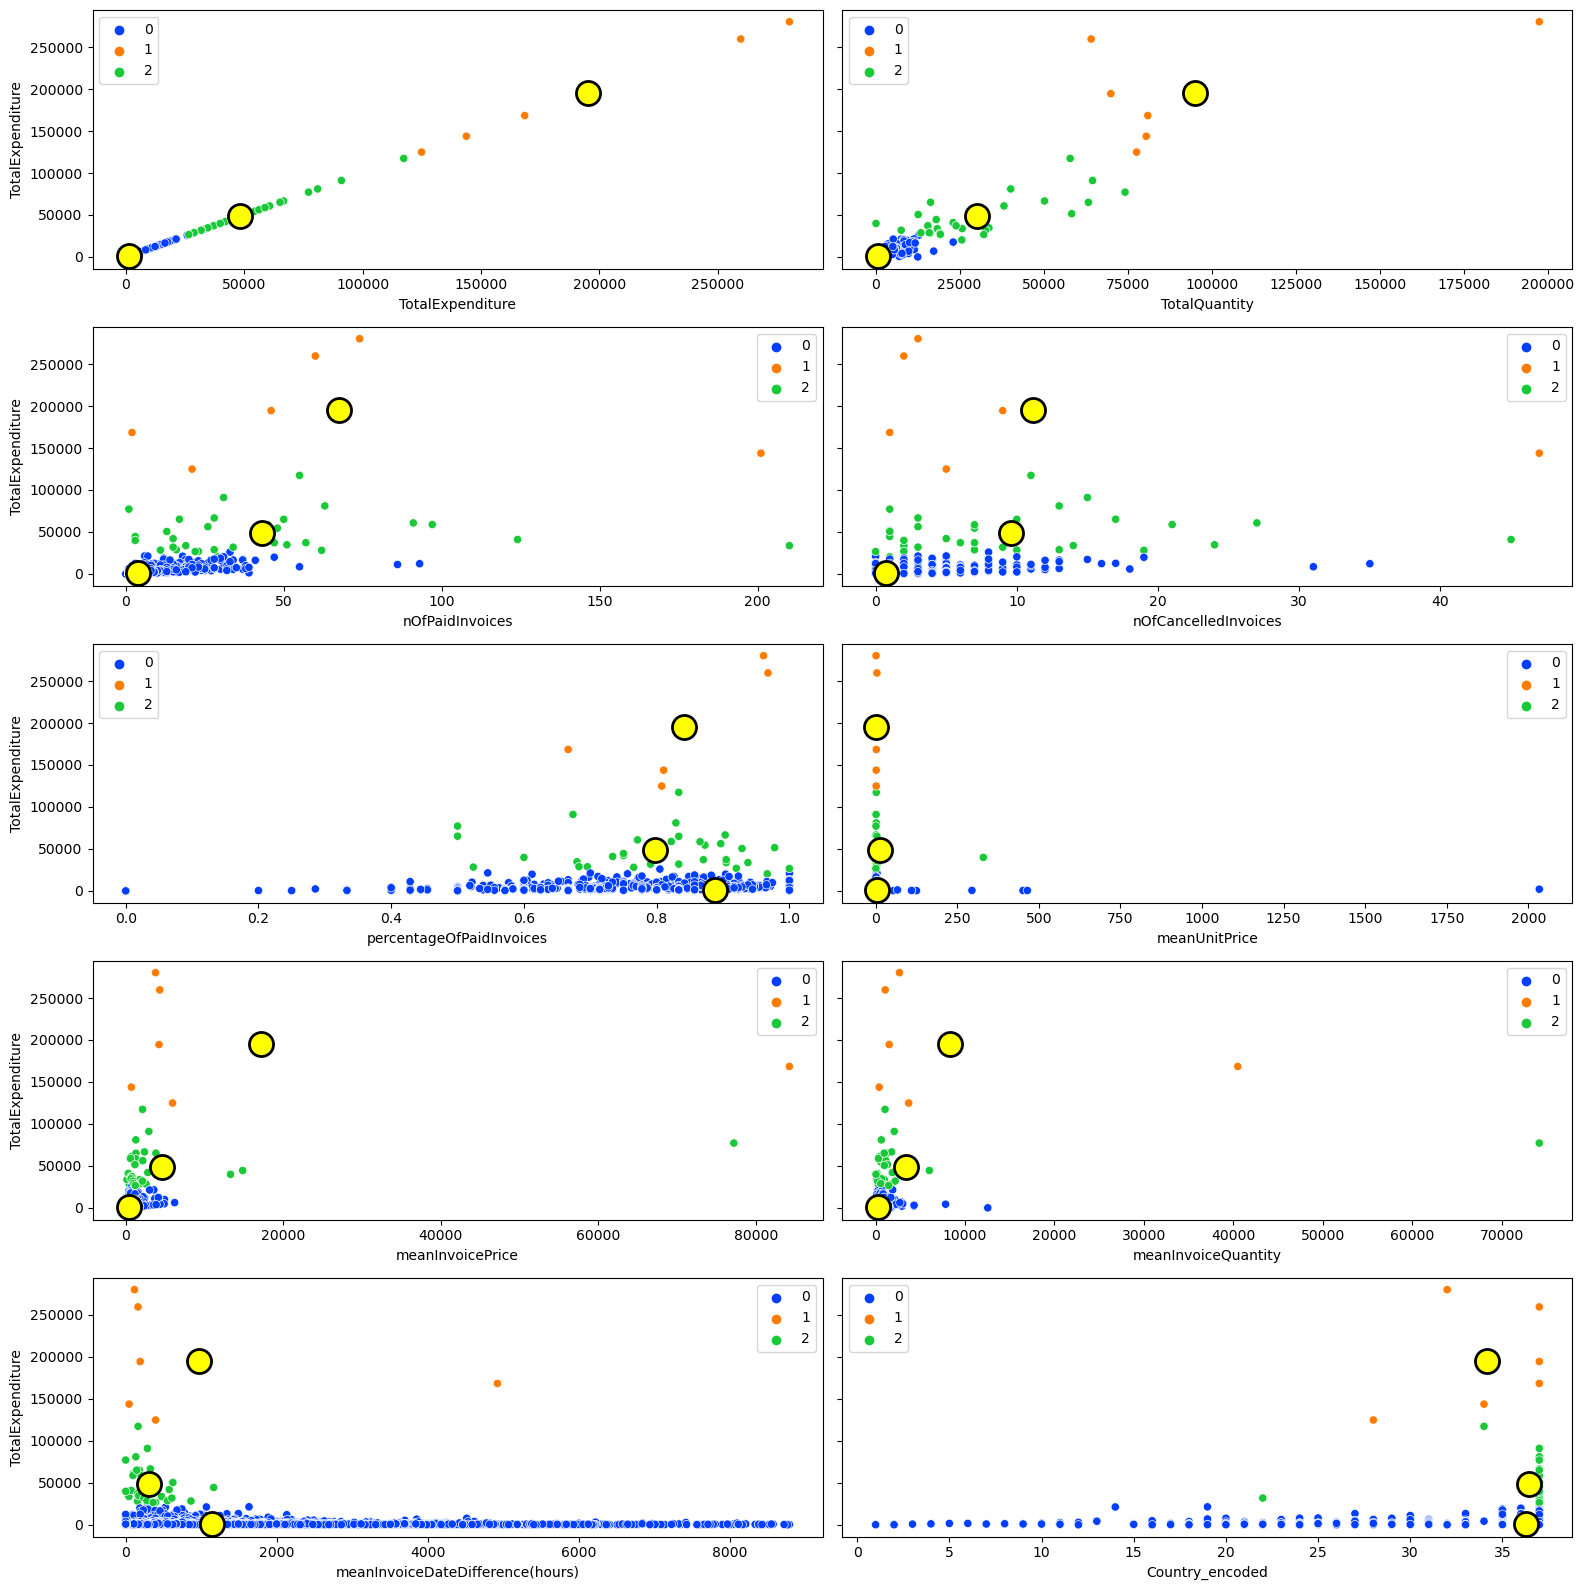

In [44]:
# Create a 5x2 grid of subplots with shared y-axis and set the figure size
fig, axes = plt.subplots(5, 2, figsize=(16, 16), sharey=True)

# Initialize an index to iterate over the columns of 'X'
ind = 0

# Loop over the rows and columns of the subplot grid
for row in range(5):
    for column in range(2):
        # In each subplot, create a scatter plot of a column of 'X' against the first column of 'X', colored by the K-Means cluster assignments
        # Also, plot the corresponding cluster center in yellow with a black outline
        sns.scatterplot(x=X.iloc[:, ind], y=X.iloc[:, 0],
                    hue= y_kmeans, palette='bright', ax=axes[row, column])
        axes[row, column].scatter(x=kmeans.cluster_centers_[:, ind], y=kmeans.cluster_centers_[:, 0],
                        s=300, color='yellow', edgecolor='black', linewidth=2)
        # Increment the index to move to the next column of 'X'
        ind += 1

# Adjust the layout for better visualization and display the plot
plt.tight_layout()
plt.show()


## Project Completed by:
[Karim Nasr](https://www.linkedin.com/in/karim-nasr-abu-al-fath/)